## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
# Machine Learning

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)

from imblearn.over_sampling import SMOTE

import xgboost as xgb


## Load Data

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT89fp3W0ZWO_NbcNb7oxYWsotVMv8QAExaz-Cgn_0dBAP_fSKsK-Q5OT5R31Xw9sT807J8eTsIhzdR/pub?gid=1104169640&single=true&output=csv')

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (10200, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,9b8f9e85-a616-44d1-afbd-b92a70ab90f3,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2025-04-28 14:44:40.468549+00:00,CA,CAD,EUR,mobile,120.43,89.12,2.38,...,0.584,STANDARD,947,0.625,0,0.268,8,9,0.0,0
1,932ddce9-c01f-4205-9223-7c0aed5c21dc,a6aa2e61-f9e4-485f-9661-f1aa5ae69410,2024-07-07 03:08:03.468549+00:00,UK,GBP,MXN,mobile,86.83,108.54,3.04,...,0.301,enhanced,803,0.882,0,0.285,8,9,0.0,0
2,cc58b06f-e434-4e22-be19-b56dbbf36203,c6d6f094-e982-46d2-8c1b-12d3af4a4bb9,2024-12-30 13:19:34.468549+00:00,CA,CAD,CNY,mobile,371.29,274.75,7.22,...,0.045,standard,172,0.881,0,0.199,8,9,0.0,0
3,1daa0060-79b6-46bd-a764-53252645b817,7041b9c1-3719-4ca8-9a6b-811b47cea6c0,2024-06-26 13:33:05.468549+00:00,UK,GBP,USD,WEB,210.64,263.29,3.61,...,0.899,STANDARD,4,0.892,0,0.407,8,8,0.0,0
4,3a0cac0d-90a2-4bfe-b05a-8e4618123ddc,66c71a44-d07c-4a20-a576-0a377193bf6b,2024-03-21 07:03:07.468549+00:00,US,USD,USD,web,344.89,344.89,5.99,...,0.889,standard,34,0.427,0,0.068,8,8,0.0,0


## Data Preparation

In [4]:
print("-- Data Info ---")
## Check data types
print(df.info())

-- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             10200 non-null  object 
 1   customer_id                10200 non-null  object 
 2   timestamp                  10171 non-null  object 
 3   home_country               10200 non-null  object 
 4   source_currency            10200 non-null  object 
 5   dest_currency              10200 non-null  object 
 6   channel                    10200 non-null  object 
 7   amount_src                 10200 non-null  object 
 8   amount_usd                 9895 non-null   float64
 9   fee                        9905 non-null   float64
 10  exchange_rate_src_to_dest  10200 non-null  float64
 11  device_id                  10200 non-null  object 
 12  new_device                 10200 non-null  bool   
 13  ip_address                 98

In [5]:
# Remove unwanted
df.drop_duplicates(inplace=True)

col = ['transaction_id', 'exchange_rate_src_to_dest', 'device_id', 'ip_address', 'ip_country', 'ip_country', 'home_country', 'source_currency', 'dest_currency']

df = df.drop(col, axis=1)

In [6]:
## Check missing values

print("\n--- Missing Values (%) ---")
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print(missing_pct[missing_pct > 0].sort_values(ascending=False))


--- Missing Values (%) ---
amount_usd            3.00
kyc_tier              2.97
fee                   2.90
device_trust_score    2.90
timestamp             0.29
dtype: float64


In [7]:
# Handle amount_src (convert from object to numeric)
df['amount_src'] = pd.to_numeric(df['amount_src'].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce' )
print(f"Converted amount_src to numeric. Missing values: {df['amount_src'].isnull().sum()}")

Converted amount_src to numeric. Missing values: 0


In [8]:
# Handle missing values

# Numeric columns - fill with median
numeric_cols_to_fill = ['amount_usd', 'fee', 'device_trust_score']
for col in numeric_cols_to_fill:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)
    print(f"Filled {col} with median: {median_val:.2f}")

Filled amount_usd with median: 151.73
Filled fee with median: 3.33
Filled device_trust_score with median: 0.78


In [9]:
# Categorical columns

print(df.kyc_tier.unique())
df['kyc_tier'] = df['kyc_tier'].str.strip().str.lower()

mapping_dict = {
    'standrd': 'standard',
    'enhancd': 'enhanced',
    'enh': 'enhanced',
    'std': 'standard',
    'unknown': None
}

df['kyc_tier'] = df['kyc_tier'].replace(mapping_dict).str.title()
df['kyc_tier'] = df['kyc_tier'].replace('Nan', None)
df['kyc_tier'] = df['kyc_tier'].fillna('Standard')
print(df.kyc_tier.unique())

['STANDARD' 'enhanced' 'standard' 'ENHANCED' 'unknown' nan 'low' 'standrd'
 'enhancd' 'LOW' 'NAN']
['Standard' 'Enhanced' 'Low']


In [10]:
print(df.channel.unique())

['mobile' 'WEB' 'web' 'ATM' 'weeb' 'mobille' 'MOBILE' 'unknown' 'ATm']


In [11]:
# Categorical columns

print(df.channel.unique())
df['channel'] = df['channel'].str.strip().str.lower()

mapping_dict = {
    'mobille': 'mobile',
    'weeb': 'web',
    'unknown': None
}

df['channel'] = df['channel'].replace(mapping_dict).str.title()
df['channel'] = df['channel'].replace('Nan', None)
df['channel'] = df['channel'].fillna('Mobile')
df['channel'] = df['channel'].replace('Atm', 'ATM')
print(df.channel.unique())

['mobile' 'WEB' 'web' 'ATM' 'weeb' 'mobille' 'MOBILE' 'unknown' 'ATm']
['Mobile' 'Web' 'ATM']


In [12]:
# Parse timestamp and extract time features
df['timestamp'].replace('0000-00-00T00:00:00Z', None)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Fill missing timestamps with median timestamp
median_timestamp = df['timestamp'].median()
df['timestamp'].fillna(median_timestamp, inplace=True)

# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

print("Time features extracted: hour, day_of_week, day_of_month, month, is_weekend, is_night")

Time features extracted: hour, day_of_week, day_of_month, month, is_weekend, is_night


In [13]:
print("\n--- Data Preparation Complete ---")
print(f"Final dataset shape: {df.shape}")
print(f"Missing values remaining: {df.isnull().sum().sum()}")


--- Data Preparation Complete ---
Final dataset shape: (10000, 24)
Missing values remaining: 0


## Exploratory Data Analysis (EDA)

In [14]:
# Target variable distribution
print("\n--- Target Variable Distribution ---")
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

print(f"Legitimate transactions: {fraud_counts[0]} ({fraud_pct[0]:.2f}%)")
print(f"Fraudulent transactions: {fraud_counts[1]} ({fraud_pct[1]:.2f}%)")
print(f"\nClass imbalance ratio: 1:{fraud_counts[0]/fraud_counts[1]:.2f}")


--- Target Variable Distribution ---
Legitimate transactions: 9805 (98.05%)
Fraudulent transactions: 195 (1.95%)

Class imbalance ratio: 1:50.28


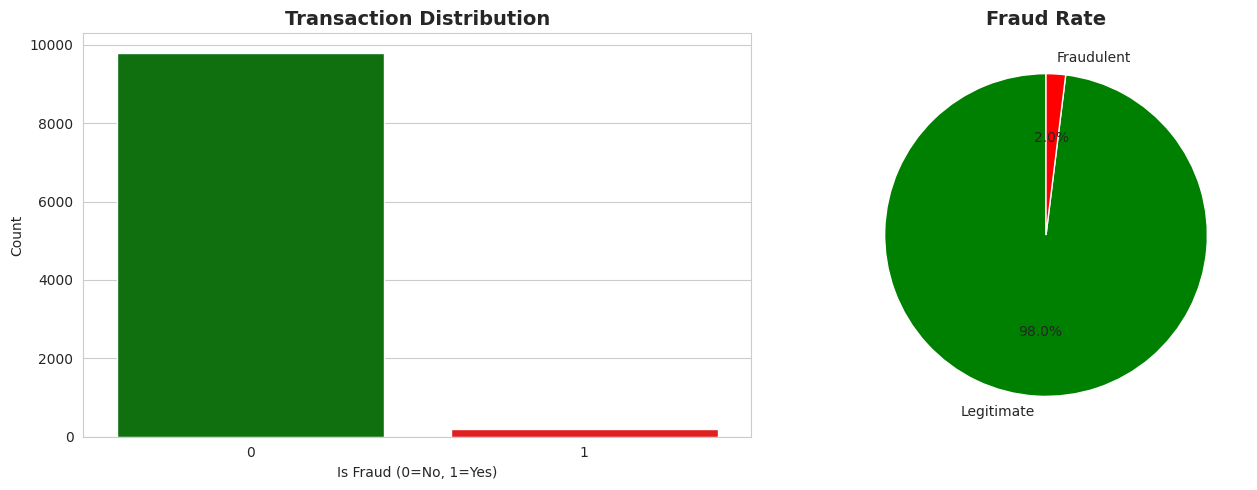

In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='is_fraud', ax=axes[0], palette=['green', 'red'])
axes[0].set_title('Transaction Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Is Fraud (0=No, 1=Yes)')
axes[0].set_ylabel('Count')

# Pie chart
axes[1].pie([fraud_counts[0], fraud_counts[1]],
           labels=['Legitimate', 'Fraudulent'],
           autopct='%1.1f%%',
           colors=['green', 'red'],
           startangle=90)
axes[1].set_title('Fraud Rate', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# Compare fraud vs legitimate transactions
print("\n--- Key Differences: Fraud vs Legitimate ---")

comparison_cols = ['amount_usd', 'fee', 'risk_score_internal', 'ip_risk_score',
                   'device_trust_score', 'account_age_days', 'corridor_risk',
                   'txn_velocity_1h', 'txn_velocity_24h', 'chargeback_history_count']

comparison_df = df.groupby('is_fraud')[comparison_cols].mean().T
comparison_df.columns = ['Legitimate', 'Fraudulent']
comparison_df['Difference (%)'] = ((comparison_df['Fraudulent'] - comparison_df['Legitimate']) /
                                    comparison_df['Legitimate'] * 100).round(2)
print(comparison_df)


--- Key Differences: Fraud vs Legitimate ---
                          Legitimate  Fraudulent  Difference (%)
amount_usd                395.171138  748.285359           89.36
fee                       104.624379  216.475949          106.91
risk_score_internal         0.240148    0.303569           26.41
ip_risk_score               0.355277    0.374723            5.47
device_trust_score          0.687223    0.710303            3.36
account_age_days          424.855482  273.358974          -35.66
corridor_risk               0.041883    0.060410           44.24
txn_velocity_1h             0.125854    0.394872          213.75
txn_velocity_24h            0.227129    0.497436          119.01
chargeback_history_count    0.002652    0.000000         -100.00


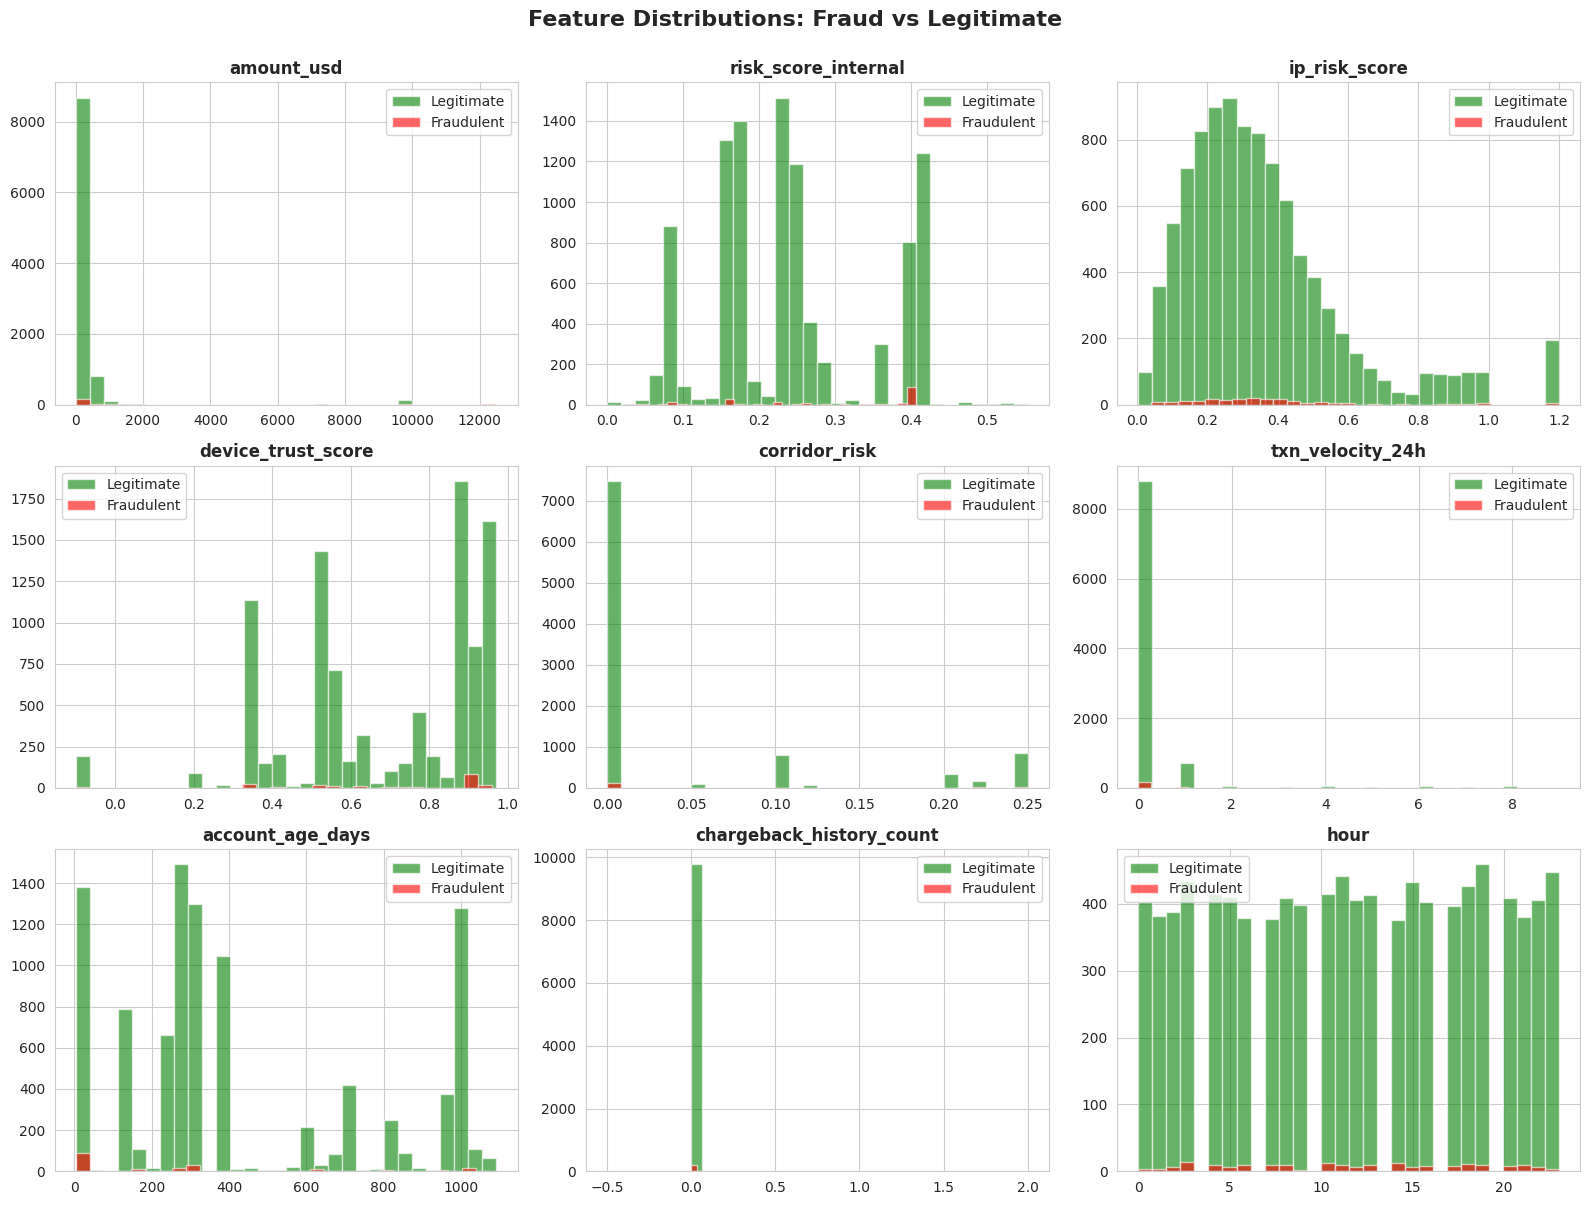

In [17]:
# Visualize key numerical features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

features_to_plot = ['amount_usd', 'risk_score_internal', 'ip_risk_score',
                    'device_trust_score', 'corridor_risk', 'txn_velocity_24h',
                    'account_age_days', 'chargeback_history_count', 'hour']

for idx, col in enumerate(features_to_plot):
    df[df['is_fraud']==0][col].hist(bins=30, alpha=0.6, label='Legitimate',
                                     color='green', ax=axes[idx])
    df[df['is_fraud']==1][col].hist(bins=30, alpha=0.6, label='Fraudulent',
                                     color='red', ax=axes[idx])
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].legend()
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions: Fraud vs Legitimate', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


--- Categorical Feature Analysis ---

CHANNEL Distribution:
         Legitimate %  Fraud %
channel                       
ATM             98.56     1.44
Mobile          98.33     1.67
Web             97.38     2.62

KYC_TIER Distribution:
          Legitimate %  Fraud %
kyc_tier                       
Enhanced         99.59     0.41
Low              96.54     3.46
Standard         97.80     2.20


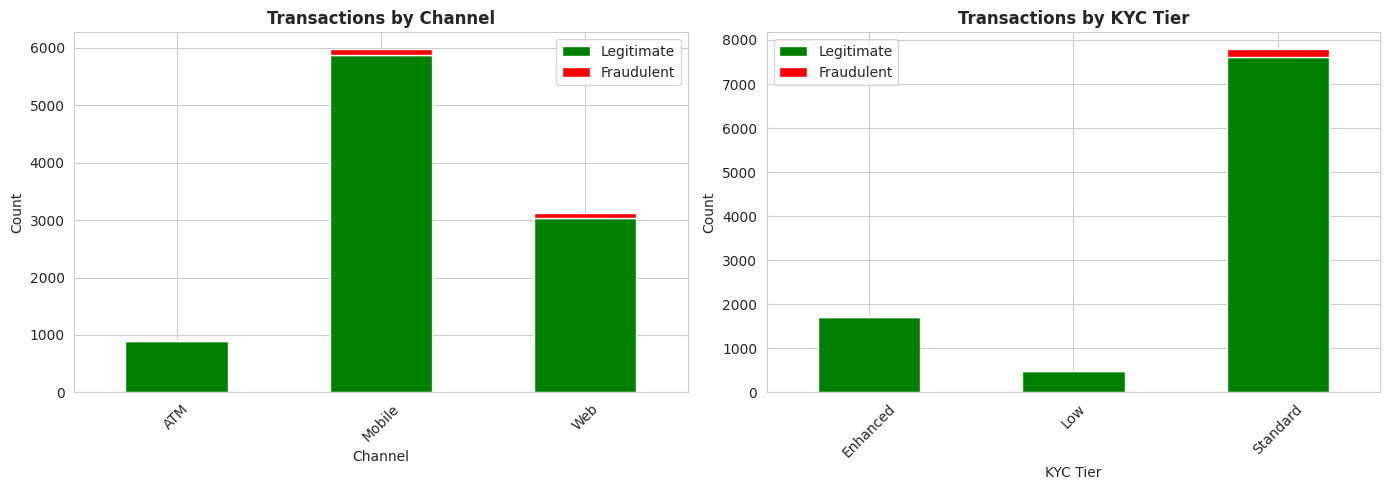

In [18]:
print("\n--- Categorical Feature Analysis ---")

categorical_cols = ['channel', 'kyc_tier']

for col in categorical_cols:  # Analyze first two to keep output manageable
    print(f"\n{col.upper()} Distribution:")
    fraud_by_cat = pd.crosstab(df[col], df['is_fraud'], normalize='index') * 100
    fraud_by_cat.columns = ['Legitimate %', 'Fraud %']
    print(fraud_by_cat.round(2))

# Visualize channel and KYC tier
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Channel
channel_fraud = df.groupby(['channel', 'is_fraud']).size().unstack(fill_value=0)
channel_fraud.plot(kind='bar', stacked=True, ax=axes[0], color=['green', 'red'])
axes[0].set_title('Transactions by Channel', fontweight='bold')
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Count')
axes[0].legend(['Legitimate', 'Fraudulent'])
axes[0].tick_params(axis='x', rotation=45)

# KYC Tier
kyc_fraud = df.groupby(['kyc_tier', 'is_fraud']).size().unstack(fill_value=0)
kyc_fraud.plot(kind='bar', stacked=True, ax=axes[1], color=['green', 'red'])
axes[1].set_title('Transactions by KYC Tier', fontweight='bold')
axes[1].set_xlabel('KYC Tier')
axes[1].set_ylabel('Count')
axes[1].legend(['Legitimate', 'Fraudulent'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


--- Correlation with Fraud ---
risk_score_internal    0.084960
txn_velocity_1h        0.039112
txn_velocity_24h       0.038029
amount_usd             0.034757
corridor_risk          0.030884
amount_src             0.029758
fee                    0.015551
device_trust_score     0.012710
ip_risk_score          0.011672
hour                   0.000975
Name: is_fraud, dtype: float64


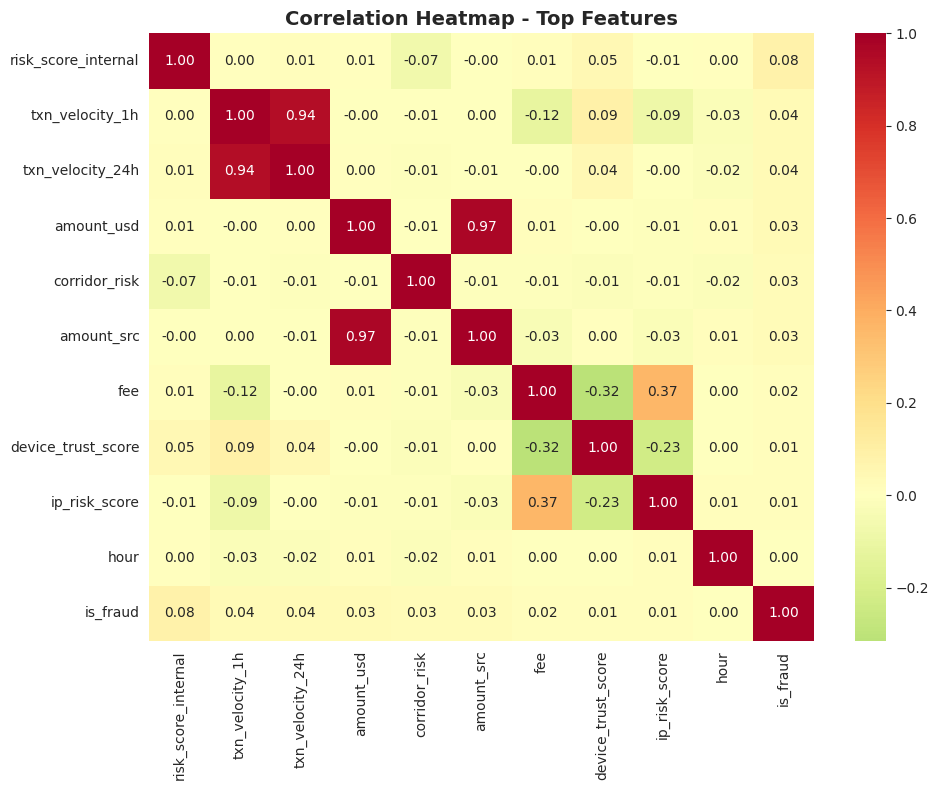

In [19]:
# Correlation analysis
print("\n--- Correlation with Fraud ---")
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('is_fraud')

correlations = df[numeric_features + ['is_fraud']].corr()['is_fraud'].sort_values(ascending=False)
print(correlations[1:11])  # Top 10 correlations

# Visualize correlation heatmap (top features)
top_features = correlations[1:11].index.tolist() + ['is_fraud']
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, fmt='.2f', cmap='RdYlGn_r', center=0)
plt.title('Correlation Heatmap - Top Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## Feature Engineering

In [20]:
# Transaction behavior features
print("\n--- Creating Transaction Behavior Features ---")

# High velocity flag
df['high_velocity_flag'] = ((df['txn_velocity_1h'] > 3) | (df['txn_velocity_24h'] > 7)).astype(int)
print(f"High velocity transactions: {df['high_velocity_flag'].sum()}")

# New account flag (less than 50 days)
df['new_account'] = (df['account_age_days'] < 50).astype(int)
print(f"New accounts: {df['new_account'].sum()}")

# Old account flag (more than 365 days)
df['old_account'] = (df['account_age_days'] > 400).astype(int)
print(f"Old accounts: {df['old_account'].sum()}")


--- Creating Transaction Behavior Features ---
High velocity transactions: 220
New accounts: 1472
Old accounts: 3046


In [21]:
# Amount-based features
print("\n--- Creating Amount-based Features ---")

# Amount to fee ratio
df['amount_to_fee_ratio'] = np.where(df['fee'] > 0, df['amount_usd'] / df['fee'], 0)
df['amount_to_fee_ratio'] = df['amount_to_fee_ratio'].replace([np.inf, -np.inf], 0)

# Log transform of amount (helps with skewed distributions)
df['log_amount'] = np.log1p(df['amount_usd'])

# Amount bins
df['amount_category'] = pd.cut(df['amount_usd'],
                                bins=[0, 100, 500, 1000, 5000, np.inf],
                                labels=['very_low', 'low', 'medium', 'high', 'very_high'])

print("Amount features created: amount_to_fee_ratio, log_amount, amount_category")


--- Creating Amount-based Features ---
Amount features created: amount_to_fee_ratio, log_amount, amount_category


In [22]:
df['risk_score_internal_normalized'] = df['risk_score_internal'] * 200
df['ip_risk_score_normalized'] = df['ip_risk_score'] * 83.33
df['corridor_risk_normalized'] = df['corridor_risk'] * 400
df['device_trust_score_normalized'] = df['device_trust_score'] * 100

In [23]:
# Risk composite scores

# Weighted risk score
df['risk_composite'] = (
    df['ip_risk_score'] * 0.30 +
    df['risk_score_internal'] * 0.30 +
    df['corridor_risk'] * 0.20 +
    df['location_mismatch'].astype(int) * 20 * 0.20
)

# Device risk score
df['device_risk'] = (
    (100 - df['device_trust_score']) * 0.6 +
    df['new_device'].astype(int) * 40 * 0.4
)

In [24]:
# Customer-level aggregations

# Average transaction amount per customer
customer_avg_amount = df.groupby('customer_id')['amount_usd'].mean()
df['customer_avg_amount'] = df['customer_id'].map(customer_avg_amount)

# Transaction count per customer
customer_txn_count = df.groupby('customer_id').size()
df['customer_txn_count'] = df['customer_id'].map(customer_txn_count)

# Deviation from customer average
df['amount_deviation'] = np.abs(df['amount_usd'] - df['customer_avg_amount'])

print(f"Customer features created: customer_avg_amount, customer_txn_count, amount_deviation")

Customer features created: customer_avg_amount, customer_txn_count, amount_deviation


In [25]:
# Interaction features

# High risk + new device
df['high_risk_new_device'] = (df['risk_score_internal'] > 50) & df['new_device']
df['high_risk_new_device'] = df['high_risk_new_device'].astype(int)

# Location mismatch + high velocity
df['location_mismatch_velocity'] = df['location_mismatch'].astype(int) * df['high_velocity_flag']

# Night transaction + high amount
df['night_high_amount'] = df['is_night'] * (df['amount_usd'] > df['amount_usd'].quantile(0.75)).astype(int)

print("Interaction features created: high_risk_new_device, location_mismatch_velocity, night_high_amount")

print("\n--- Feature Engineering Complete ---")

#Check total featues
print(f"Total features now: {df.shape[1]}")

Interaction features created: high_risk_new_device, location_mismatch_velocity, night_high_amount

--- Feature Engineering Complete ---
Total features now: 42


In [26]:
# Summary of new features
new_features = ['high_velocity_flag', 'new_account', 'old_account', 'amount_to_fee_ratio',
                'log_amount', 'risk_score_internal_normalized', 'ip_risk_score_normalized',
                'corridor_risk_normalized', 'device_trust_score_normalized',
                'risk_composite', 'device_risk', 'customer_avg_amount',
                'customer_txn_count', 'amount_deviation', 'high_risk_new_device',
                'location_mismatch_velocity', 'night_high_amount']

print(f"\nEngineered {len(new_features)} new features:")
for feat in new_features:
    print(f"  - {feat}")


Engineered 17 new features:
  - high_velocity_flag
  - new_account
  - old_account
  - amount_to_fee_ratio
  - log_amount
  - risk_score_internal_normalized
  - ip_risk_score_normalized
  - corridor_risk_normalized
  - device_trust_score_normalized
  - risk_composite
  - device_risk
  - customer_avg_amount
  - customer_txn_count
  - amount_deviation
  - high_risk_new_device
  - location_mismatch_velocity
  - night_high_amount


## Model Preparation

In [27]:
# Select features for modeling
print("\n--- Selecting Features ---")

# Features to use in the model
feature_columns = [
    # Risk scores
    'risk_score_internal', 'ip_risk_score', 'corridor_risk', 'risk_composite', 'device_risk',

    # Transaction patterns
    'txn_velocity_1h', 'txn_velocity_24h', 'high_velocity_flag',

    # Account characteristics
    'account_age_days', 'new_account', 'old_account', 'device_trust_score',
    'chargeback_history_count',

    # Transaction details
    'amount_usd', 'log_amount', 'fee', 'amount_to_fee_ratio',

    # Behavioral flags
    'new_device', 'location_mismatch',

    # Time features
    'hour', 'day_of_week', 'is_weekend', 'is_night',

    # Customer patterns
    'customer_txn_count', 'amount_deviation',

    # Interaction features
    'high_risk_new_device', 'location_mismatch_velocity', 'night_high_amount'
]



--- Selecting Features ---


In [28]:
# Convert boolean columns to int
bool_cols = df[feature_columns].select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

X = df[feature_columns].copy()
y = df['is_fraud'].copy()

print(f"Selected {len(feature_columns)} features for modeling")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Selected 28 features for modeling
Feature matrix shape: (10000, 28)
Target distribution: {0: 9805, 1: 195}


In [29]:
# Train-test split
print("\n--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train fraud rate: {y_train.mean():.2%}")
print(f"Test fraud rate: {y_test.mean():.2%}")


--- Splitting Data ---
Training set: 8000 samples
Test set: 2000 samples
Train fraud rate: 1.95%
Test fraud rate: 1.95%


In [30]:
# Handle class imbalance with SMOTE
print(f"Before SMOTE - Train class distribution:")
print(y_train.value_counts())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE - Train class distribution:")
print(pd.Series(y_train_balanced).value_counts())

Before SMOTE - Train class distribution:
is_fraud
0    7844
1     156
Name: count, dtype: int64

After SMOTE - Train class distribution:
is_fraud
0    7844
1    7844
Name: count, dtype: int64


In [31]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## Model Training and Evaluation

In [32]:
# Store results for comparison
model_results = {}

# 7.1 Logistic Regression
print("\n--- Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train_balanced)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]


--- Training Logistic Regression ---


In [33]:
# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

model_results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'auc': lr_auc
}

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"ROC-AUC: {lr_auc:.4f}")

Accuracy: 0.8610
Precision: 0.0421
Recall: 0.2821
F1-Score: 0.0733
ROC-AUC: 0.5854


In [34]:
# Random Forest
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

model_results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1': rf_f1,
    'auc': rf_auc
}

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_auc:.4f}")


--- Training Random Forest ---
Accuracy: 0.9125
Precision: 0.0405
Recall: 0.1538
F1-Score: 0.0642
ROC-AUC: 0.6861


In [35]:
# XGBoost
print("\n--- Training XGBoost ---")

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train_balanced[y_train_balanced==0]) / len(y_train_balanced[y_train_balanced==1])

xgb_model = xgb.XGBClassifier(
  n_estimators=100,
  max_depth=6,
  learning_rate=0.1,
  scale_pos_weight=scale_pos_weight,
  random_state=42,
  eval_metric='logloss'
)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

model_results['XGBoost'] = {
    'accuracy': xgb_accuracy,
    'precision': xgb_precision,
    'recall': xgb_recall,
    'f1': xgb_f1,
    'auc': xgb_auc
}

print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")
print(f"ROC-AUC: {xgb_auc:.4f}")


--- Training XGBoost ---
Accuracy: 0.9475
Precision: 0.0286
Recall: 0.0513
F1-Score: 0.0367
ROC-AUC: 0.6143


## Model Comparison and Visualization

MODEL COMPARISON

                      accuracy  precision  recall      f1     auc
Logistic Regression    0.8610     0.0421  0.2821  0.0733  0.5854
Random Forest          0.9125     0.0405  0.1538  0.0642  0.6861
XGBoost                0.9475     0.0286  0.0513  0.0367  0.6143


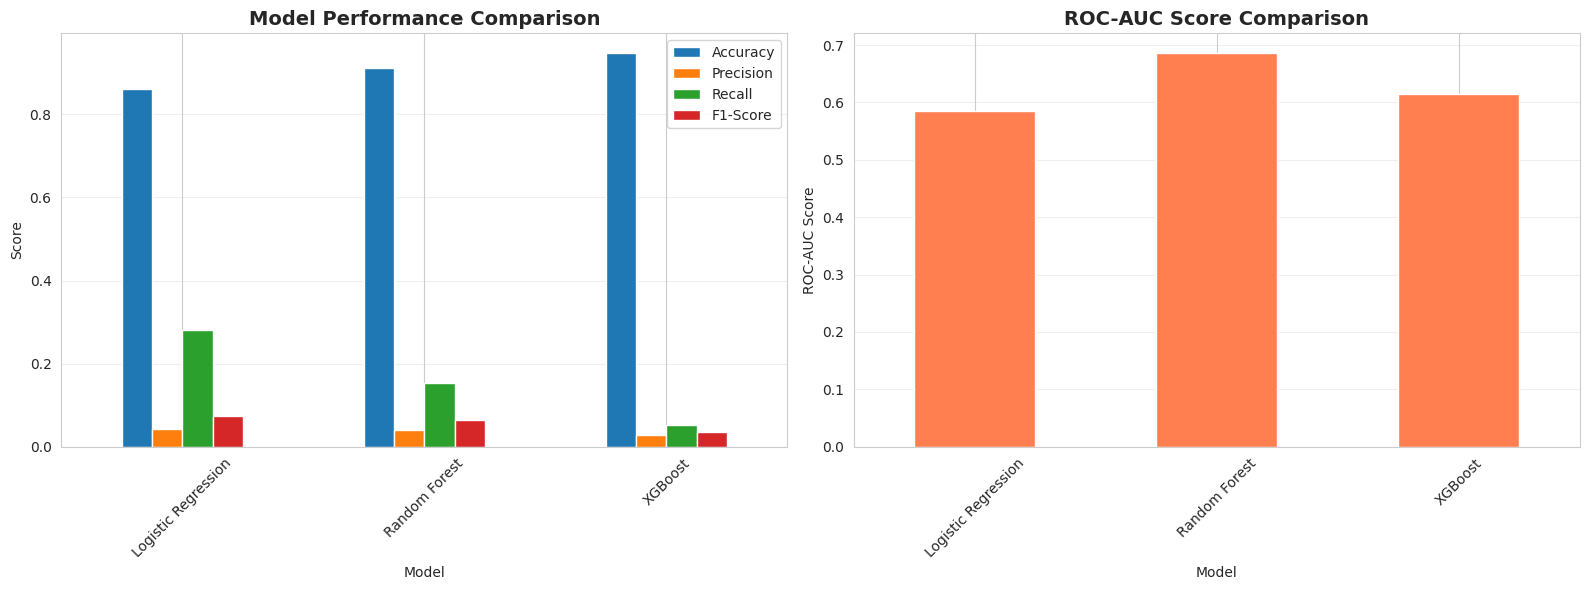

In [36]:
print("MODEL COMPARISON")
print("="*60)

# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
print("\n", results_df)

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
results_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# ROC-AUC comparison
results_df['auc'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('ROC-AUC Score Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Best Model Selection

In [37]:
# Select best model based on F1 score
best_model_name = results_df['f1'].idxmax()
print(f"\n--- Best Model: {best_model_name} ---")

# Use Random Forest for detailed analysis
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
    X_for_prediction = X_test_scaled
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf
    X_for_prediction = X_test
else:  # XGBoost
    best_model = xgb_model
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
    X_for_prediction = X_test


--- Best Model: Logistic Regression ---



--- Confusion Matrix ---
[[1711  250]
 [  28   11]]


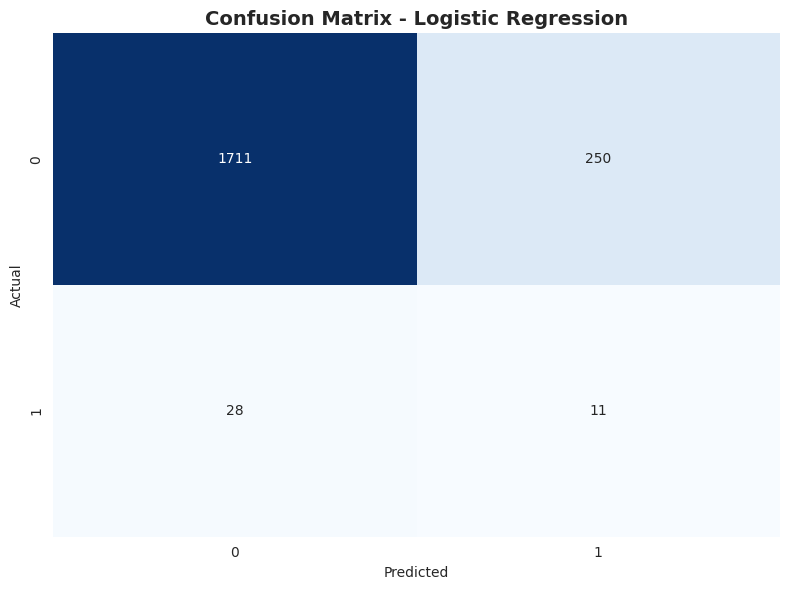

In [38]:
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [39]:
# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_best, target_names=['Legitimate', 'Fraud']))


--- Classification Report ---
              precision    recall  f1-score   support

  Legitimate       0.98      0.87      0.92      1961
       Fraud       0.04      0.28      0.07        39

    accuracy                           0.86      2000
   macro avg       0.51      0.58      0.50      2000
weighted avg       0.97      0.86      0.91      2000




FEATURE IMPORTANCE

Top 15 Most Important Features:
                feature  importance
18    location_mismatch    0.207494
21           is_weekend    0.164103
22             is_night    0.114266
8      account_age_days    0.070321
2         corridor_risk    0.062761
17           new_device    0.058968
7    high_velocity_flag    0.047663
11   device_trust_score    0.033624
0   risk_score_internal    0.029121
3        risk_composite    0.027759
6      txn_velocity_24h    0.020927
19                 hour    0.020548
5       txn_velocity_1h    0.019672
4           device_risk    0.017518
23   customer_txn_count    0.016788


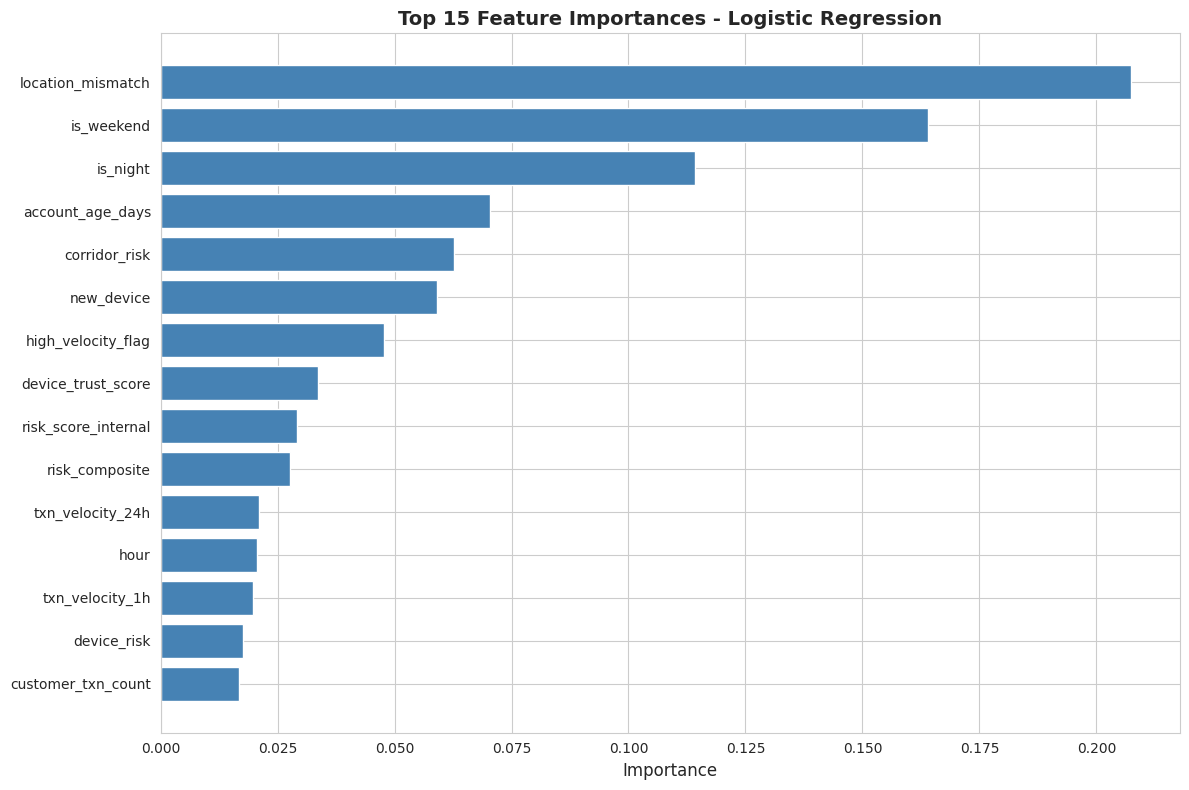

In [40]:
# Feature Importance

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

if best_model_name == 'Random Forest' or 'XGBoost':
    # Get feature importance
    if best_model_name == 'Random Forest':
        importances = rf_model.feature_importances_
    else:
        importances = xgb_model.feature_importances_

    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15))

    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Logistic Regression':
    # For Logistic Regression, use coefficients
    coefficients = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': lr_model.coef_[0]
    })
    coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
    coefficients = coefficients.sort_values